In [2]:
import pandas as pd
import numpy as np
import time
import os
import pickle
import sys
from datetime import datetime, timedelta

%matplotlib inline

In [ ]:
full_dict = {}
count = 0
subj_list = ([1004,1016,1018,1019,1020,1024,1029,1030,1032,1038,1044,1046,1047,1049,1051,1052,1053,1054,1055,1056])
for subj in subj_list:
    f = open('//FS2.smpp.local\\RTO\\CIS-PD Study\\Data_dict\\' + str(subj) + 'dict.pkl', 'rb')
    t_dict = {}
    s = (pickle.load(f))
    
    
    for t in ['Heart Rate Variability', 'MDS-UPDRS #1: Finger Tapping', 'MDS-UPDRS #2: Hand Movements', 
              'MDS-UPDRS #3: Pronation-Supination', 'MDS-UPDRS #4: Toe Tapping', 'MDS-UPDRS #5: Leg Agility', 
              'MDS-UPDRS #6: Arising from Chair', 'MDS-UPDRS #7: Gait', 'MDS-UPDRS #8: Postural Stability', 
              'MDS-UPDRS #9: Postural Hand Tremor', 'MDS-UPDRS #10: Kinetic Hand Tremor']:
        t_dict[t] = s[t]
        
    full_dict[subj] = t_dict
    f.close()
    count = count + 1
    if count < 10:
        print(' ' + str(count) + ' of 20 subjects loaded')
    else:
        print(str(count) + ' of 20 subjects loaded')

In [ ]:
with open('MDS-UPDRS Data.pkl', 'wb') as handle:
    pickle.dump(full_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
def getSplitPoint(R,L,n=10,dropPercent = .25):
    
    if dropPercent>.5:
        print('dropPercent must be between 0 and .5 - using 0')
        dropPercent = 0
    
    startWin = dropPercent
    endWin = 1-dropPercent
    
    vals = (R-1).abs().rolling(n).sum().reset_index()>(L-1).abs().rolling(n).sum().reset_index()
    
    vals = vals.values[int(startWin*len(L)):int(endWin*len(L))][:,1]
    
    return R.index[np.argmax(vals<.5)+int(startWin*len(R))-n]

In [4]:
def splitLeftRight(taskList, ref_Sens, full_dict):
    for t in taskList:
        for s in full_dict.keys():
            
            VRdict = {}
            VLdict = {}
            
            for v in full_dict[s][t].keys():
                
                splitInd=[]
                for sens in ref_Sens:
                    rSens = sens + 'right'
                    lSens = sens + 'left'

                    R, L = full_dict[s][t][v][rSens]['accel'], full_dict[s][t][v][lSens]['accel']
                    R = R.apply(lambda x: np.sqrt(x['Accel X (g)']**2+x['Accel Y (g)']**2+x['Accel Z (g)']**2), axis=1)
                    L = L.apply(lambda x: np.sqrt(x['Accel X (g)']**2+x['Accel Y (g)']**2+x['Accel Z (g)']**2), axis=1)

                    #interpolate the data to same timepoints
                    indStart = min(R.index.min(),L.index.min())
                    indStop = max(R.index.max(),L.index.max())
                    newPoints = np.array(range(indStart,indStop+1,16))

                    R = pd.Series(data = np.interp(newPoints,R.index,R.values), index = newPoints)
                    L = pd.Series(data = np.interp(newPoints,L.index,L.values), index = newPoints)

                    splitInd.append(getSplitPoint(R,L))
                if max(abs(max(splitInd-np.mean(splitInd)))>500,abs(np.mean(splitInd)-np.mean([indStart, indStop])))>500:
                    print('Check ', s, t, v)
                splitInd=np.mean(splitInd)
                
#                 print(s, t, v, splitInd)
                
                ## Check minimum and maximum times and align all sensors
                minStamp = sys.maxsize
                maxStamp = 0
                for sens in full_dict[s][t][v].keys():
                    if len(full_dict[s][t][v][sens]['accel'])<1:
                        continue
                    minStamp = min(minStamp,full_dict[s][t][v][sens]['accel'].index.min())
                    maxStamp = max(maxStamp,full_dict[s][t][v][sens]['accel'].index.max())

                Rdict = {}
                Ldict = {}
                ## Get new Left and Right data for tasks
                for sens in full_dict[s][t][v].keys():
                    SRdict = {}
                    SLdict = {}
                    for mode in full_dict[s][t][v][sens].keys():
                        data = full_dict[s][t][v][sens][mode]
                        if len(data)<1:
                            SRdict[mode] = data.copy()
                            SLdict[mode] = data.copy()
                            print(SRdict)
                            continue

                        if mode=='elec':
                            ts = 1
                        else:
                            ts = 16

                        newPoints = np.array(range(minStamp,maxStamp+1,ts))
                        data = pd.DataFrame(data = np.array([np.interp(newPoints,data.index,data.loc[:,c].values) for c in data.columns]).transpose(), 
                                         index = newPoints,
                                         columns = [c for c in data.columns])
                        SRdict[mode] = data[data.index<splitInd].copy()
                        SLdict[mode] = data[data.index>=splitInd].copy()

                    Rdict[sens] = SRdict
                    Ldict[sens] = SLdict

#                 print(s, t, v, len(Rdict['dorsal_hand_right']['accel']), len(Ldict['dorsal_hand_right']['accel']))
                VRdict[v] = Rdict
                VLdict[v] = Ldict

#             print(VRdict.keys(), VLdict.keys())
            full_dict[s][t + ' - Right'] = VRdict
            full_dict[s][t + ' - Left'] = VLdict

In [5]:
with open('MDS-UPDRS Data.pkl', 'rb') as handle:
    full_dict = pickle.load(handle)

## Fix erroneous runs

In [ ]:
def fixIndividualRun(s,t,v,ref_Sens,start=0,stop=1,n=10,drop=.25,offset=0):

    splitInd=[]
    for sens in ref_Sens:
        rSens = sens + 'right'
        lSens = sens + 'left'

        R, L = full_dict[s][t][v][rSens]['accel'], full_dict[s][t][v][lSens]['accel']
        R = R.iloc[int(start*len(R)):int(stop*len(R))-1]
        L = L.iloc[int(start*len(L)):int(stop*len(L))-1]
        R = R.apply(lambda x: np.sqrt(x['Accel X (g)']**2+x['Accel Y (g)']**2+x['Accel Z (g)']**2), axis=1)
        L = L.apply(lambda x: np.sqrt(x['Accel X (g)']**2+x['Accel Y (g)']**2+x['Accel Z (g)']**2), axis=1)

        #interpolate the data to same timepoints
        indStart = min(R.index.min(),L.index.min())
        indStop = max(R.index.max(),L.index.max())
        newPoints = np.array(range(indStart,indStop+1,16))

        R = pd.Series(data = np.interp(newPoints,R.index,R.values), index = newPoints)
        L = pd.Series(data = np.interp(newPoints,L.index,L.values), index = newPoints)

        splitInd.append(getSplitPoint(R,L,n,drop))
    print(splitInd)
    if max(abs(max(splitInd-np.mean(splitInd)))>500,abs(np.mean(splitInd)-np.mean([indStart, indStop])))>500:
        print('Check ', s, t, v)
    splitInd=np.mean(splitInd)+offset

    ## Check minimum and maximum times and align all sensors
    minStamp = sys.maxsize
    maxStamp = 0
    for sens in full_dict[s][t][v].keys():
        if len(full_dict[s][t][v][sens]['accel'])<1:
            continue
        minStamp = min(minStamp,full_dict[s][t][v][sens]['accel'].index.min())
        maxStamp = max(maxStamp,full_dict[s][t][v][sens]['accel'].index.max())

    Range = maxStamp - minStamp
    maxStamp = minStamp + int(stop*Range)
    minStamp = minStamp + int(start*Range)
        
    Rdict = {}
    Ldict = {}
    ## Get new Left and Right data for tasks
    for sens in full_dict[s][t][v].keys():
        SRdict = {}
        SLdict = {}
        for mode in full_dict[s][t][v][sens].keys():
            data = full_dict[s][t][v][sens][mode]
            if len(data)<1:
                continue

            if mode=='elec':
                ts = 1
            else:
                ts = 16

            newPoints = np.array(range(minStamp,maxStamp+1,ts))
            data = pd.DataFrame(data = np.array([np.interp(newPoints,data.index,data.loc[:,c].values) for c in data.columns]).transpose(), 
                             index = newPoints,
                             columns = [c for c in data.columns])
            SRdict[mode] = data[data.index<splitInd].copy()
            SLdict[mode] = data[data.index>=splitInd].copy()

        Rdict[sens] = SRdict
        Ldict[sens] = SLdict

    Rdict = {v: Rdict}
    Ldict = {v: Ldict}

    full_dict[s][t + ' - Right'] = Rdict
    full_dict[s][t + ' - Left'] = Ldict

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1004
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1016
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1018
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.24)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1018
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.15,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1018
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1019
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1019
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1020
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1024
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1024
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.15,n=20,offset=250)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1024
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1029
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1030
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.15,n=20,offset=250)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1030
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.15,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1030
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=250)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1032
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1032
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,offset=3750, stop=.87)

In [ ]:
full_dict[1038][t][2] = full_dict[1038][t][3]
full_dict[1038]['MDS-UPDRS #5: Leg Agility'][2] = full_dict[1038]['MDS-UPDRS #5: Leg Agility'][1]

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1038
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1044
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1046
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1046
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1047
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1049
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=0.13,offset=250)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1052
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,stop=.95,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1053
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1054
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.15,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1055
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.18,n=20,offset=50)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1055
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,n=20,offset=100)

In [ ]:
t = 'MDS-UPDRS #4: Toe Tapping'
s = 1056
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1004
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1004
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,stop=.95,n=20,offset=100)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1004
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1016
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1018
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.15,n=20,offset=100)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1019
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.03,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1019
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1020
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1020
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1024
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.15,n=20,offset=150)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1029
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.12,n=20,offset=0)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1029
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=100)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1032
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.17,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1032
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1038
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1044
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1044
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=100)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1044
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=20,offset=150)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1046
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.07,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1047
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1047
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,stop=.92,n=20,offset=100)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1049
v = 2
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1051
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.07,stop=.93,n=20,offset=150)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1052
v = 0
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1052
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1053
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1054
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,start=.15,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #5: Leg Agility'
s = 1055
v = 1
ref_Sens = ['anterior_thigh_', 'distal_lateral_shank_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=200)

## Upper Extremity Splits

In [ ]:
splitLeftRight(['MDS-UPDRS #1: Finger Tapping', 'MDS-UPDRS #2: Hand Movements', 
                'MDS-UPDRS #3: Pronation-Supination', 'MDS-UPDRS #10: Kinetic Hand Tremor'], 
               ['dorsal_hand_', 'flexor_digitorum_'], 
               full_dict)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1004
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1016
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=50)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1016
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=4750)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1016
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=300)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1018
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=0)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1018
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=0)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1019
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=1750)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1019
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=20,drop=.3,offset=2500)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1019
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=0)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1020
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=250)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1020
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=300)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1020
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=0)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1024
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,n=20,offset=2100)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1024
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.15,n=30,offset=1800)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1024
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=0)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1029
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0,n=20,offset=300)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1029
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=250)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1030
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,n=30,offset=250)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1030
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0,n=20,offset=0)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1030
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,n=30,offset=3000)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1032
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1032
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=250)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1038
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=250)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1038
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1038
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=20,offset=500)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1044
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,n=30,offset=750)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1044
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,n=30,offset=3750)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1044
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0.15,n=20,offset=1300)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1046
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=750)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1046
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=250)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1046
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=750)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1047
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0,n=30,offset=250)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1049
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,n=30,offset=4750)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1049
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0.05,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1049
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,n=30,offset=1250)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1051
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=250)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1052
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=750)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1052
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0.12,n=20,offset=1500)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1053
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=1000)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1053
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.25,n=30,offset=750)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1054
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0.02,n=20,offset=3000)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1054
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,stop=.95,n=30,offset=750)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1055
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=250)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1055
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.15,n=30,offset=750)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1056
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0.05,n=20,offset=250)

In [ ]:
t = 'MDS-UPDRS #1: Finger Tapping'
s = 1056
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,n=30,offset=2500)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1016
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=250)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1018
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1019
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0.02,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1019
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0,n=20,offset=1250)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1020
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=0)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1024
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=0)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1024
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=250)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1024
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0.05,n=20,offset=0)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1029
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1029
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1030
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0.2,n=20,offset=100)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1030
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0.05,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1032
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=0)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1038
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1038
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1038
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=250)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1044
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=300)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1044
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1046
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=250)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1047
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=0)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1049
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,n=30,offset=5000)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1049
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=1000)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1049
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1051
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1051
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1052
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1052
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1053
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=0)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1054
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0.1,n=20,offset=2200)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1055
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1056
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #2: Hand Movements'
s = 1056
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1004
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1004
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1016
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=0)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1016
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1018
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=0)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1019
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=250)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1029
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1029
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=250)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1030
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.15,n=30,offset=0)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1032
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1032
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1038
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1038
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1044
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1044
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1044
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1046
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0,n=20,offset=400)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1046
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1049
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=3500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1049
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1049
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.25,n=30,offset=1000)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1051
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=0)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1052
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1053
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1054
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0,n=20,offset=400)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1055
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1056
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0,n=20,offset=200)

In [ ]:
t = 'MDS-UPDRS #3: Pronation-Supination'
s = 1056
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1004
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.52,stop=.85,n=30,offset=1200)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1004
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,stop=.9,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1016
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,stop=.9,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1016
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,stop=.95,offset=-500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1018
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1018
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1019
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.2,n=30,offset=3500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1019
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,n=30,offset=250)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1020
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,stop=.9,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1024
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,n=30,offset=2500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1024
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.15,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1024
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,stop=.9,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1029
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=1000)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1029
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=2500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1029
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0.15,n=20,offset=1500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1030
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=1500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1030
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=0,n=20,offset=-1200)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1030
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,stop=.9,n=30,offset=250)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1032
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,stop=.9,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1032
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,stop=.9,n=30,offset=1500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1032
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1038
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.2,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1038
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=1000)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1044
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.15,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1044
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,stop=.9,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1044
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1046
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.2,n=30,offset=750)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1046
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1046
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1047
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=1000)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1047
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.15,stop=.9,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1047
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1049
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.35,n=30,offset=1500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1049
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=1000)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1049
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1051
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1051
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1051
v = 2
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1052
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1052
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1053
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1053
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1054
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=3000)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1054
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,n=30,offset=500)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1055
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.15,n=30,offset=1000)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1056
v = 0
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.1,n=30,offset=3250)

In [ ]:
t = 'MDS-UPDRS #10: Kinetic Hand Tremor'
s = 1056
v = 1
ref_Sens = ['dorsal_hand_', 'flexor_digitorum_']

fixIndividualRun(s,t,v,ref_Sens,start=.05,n=30,offset=1000)

In [ ]:
full_dict[s][t][v][ref_Sens[1]+'right']['accel'].plot()

In [ ]:
full_dict[s][t + ' - Right'][v][ref_Sens[1]+'right']['accel'].plot()

In [ ]:
full_dict[s][t + ' - Right'][v][ref_Sens[1]+'left']['accel'].plot()

In [ ]:
full_dict[s][t + ' - Left'][v][ref_Sens[1]+'right']['accel'].plot()

In [ ]:
full_dict[s][t + ' - Left'][v][ref_Sens[1]+'left']['accel'].plot()

In [ ]:
with open('MDS-UPDRS Data - Split.pkl', 'wb') as handle:
    pickle.dump(full_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Add Resting Tremor to Dictionary

In [ ]:
with open('MDS-UPDRS Data - Split.pkl', 'rb') as handle:
    full_dict = pickle.load(handle)

In [ ]:
t = 'MDS-UPDRS #11: Rest Tremor'
path = '//FS2.smpp.local\\RTO\\CIS-PD Study\\Subjects\\'
for s in full_dict.keys():
    s = str(s)
    print(s)
    times = pd.read_csv(os.path.join(path,str(s),'annotations.csv'))
    
    t_dict = {}
    for row in times[times['EventType']==t].iterrows():
        if row[0]<20:
            v = 0
        elif row[0]<100:
            v = 1
        else:
            v = 2
        
        minStamp = row[1]['Start Timestamp (ms)']
        maxStamp = row[1]['Stop Timestamp (ms)']
        
        v_dict = {}
        sensList = [sens for sens in os.listdir(os.path.join(path,s)) if sens[-3:]!='csv']
        for sens in sensList:
            print(sens)
            accDF = pd.DataFrame(columns = ['Accel X (g)', 'Accel Y (g)', 'Accel Z (g)'])
            accDF.index.name = 'Timestamp (ms)'
            
            gyrDF = pd.DataFrame(columns = ['Gyro X (°/s)', 'Gyro Y (°/s)', 'Gyro Z (°/s)'])
            gyrDF.index.name = 'Timestamp (ms)'
            
            emgDF = pd.DataFrame(columns = ['Sample (V)'])
            emgDF.index.name = 'Timestamp (ms)'
            
            
            sensIDs = os.listdir(os.path.join(path,s,sens))
            for SID in sensIDs:
                recDates = os.listdir(os.path.join(path,s,sens,SID))
                for rec in recDates:
                    dataFiles = os.listdir(os.path.join(path,s,sens,SID,rec))
                    for f in dataFiles:
                        if f =='accel.csv':
                            data = pd.read_csv(os.path.join(path,s,sens,SID,rec,f), index_col=[0])
                            data = data[(data.index>minStamp) & (data.index<maxStamp)]
                            accDF = accDF.append(data)
                        if f =='gyro.csv':
                            data = pd.read_csv(os.path.join(path,s,sens,SID,rec,f), index_col=[0])
                            data = data[(data.index>minStamp) & (data.index<maxStamp)]
                            gyrDF = gyrDF.append(data)
                        if f =='elec.csv':
                            data = pd.read_csv(os.path.join(path,s,sens,SID,rec,f))#, index_col=[0])
                            data.index=data['Timestamp (ms)']
                            data.drop(columns=['Timestamp (ms)'], inplace=True)
                            data = data[(data.index>minStamp) & (data.index<maxStamp)]
                            emgDF = emgDF.append(data)
            
            print(len(accDF),len(gyrDF),len(emgDF))
            s_dict = {'accel': accDF, 'gyro': gyrDF, 'elec': emgDF}
            v_dict[sens] = s_dict
            
        t_dict[v] = v_dict
        
    full_dict[float(s)][t] = t_dict

1004
anterior_thigh_left
555 555 0
sacrum
556 556 0
distal_lateral_shank_right
555 555 0
dorsal_hand_left
557 557 0
flexor_digitorum_left


## Resample all sensors to same indices

In [ ]:
path = '//FS2.smpp.local\\RTO\\CIS-PD Study\\Subjects\\'
taskList = ['Heart Rate Variability', 'MDS-UPDRS #1: Finger Tapping', 'MDS-UPDRS #2: Hand Movements', 
            'MDS-UPDRS #3: Pronation-Supination', 'MDS-UPDRS #4: Toe Tapping', 'MDS-UPDRS #5: Leg Agility', 
            'MDS-UPDRS #6: Arising from Chair', 'MDS-UPDRS #7: Gait', 'MDS-UPDRS #8: Postural Stability', 
            'MDS-UPDRS #9: Postural Hand Tremor', 'MDS-UPDRS #10: Kinetic Hand Tremor', 'MDS-UPDRS #11: Resting Tremor']

for s in full_dict.keys():
    print(str(s))
    times = pd.read_csv(os.path.join(path,str(s),'annotations.csv'))
    for t in full_dict[s].keys():
        print(t)
        for v in full_dict[s][t].keys():
            minStamp = sys.maxsize
            maxStamp = 0
            for sens in full_dict[s][t][v].keys():
                for data in [d for d in full_dict[s][t][v][sens].values() if len(d)>0]:
                    minStamp = min(minStamp,data.index.min())
                    maxStamp = max(maxStamp,data.index.max())
                    
                for mode in full_dict[s][t][v][sens].keys():
                    data = full_dict[s][t][v][sens][mode]
                    if len(data)<1:
                        continue

                    if mode=='elec':
                        ts = 1
                    else:
                        ts = 16

                    newPoints = np.array(range(minStamp,maxStamp+1,ts))
                    data = pd.DataFrame(data = np.array([np.interp(newPoints,data.index,data.loc[:,c].values) 
                                                         for c in data.columns]).transpose(), 
                                     index = newPoints,
                                     columns = [c for c in data.columns])

In [ ]:
with open('MDS-UPDRS Data - Resampled.pkl', 'wb') as handle:
    pickle.dump(full_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

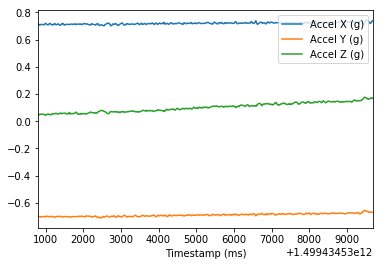

In [11]:
full_dict[1004]['MDS-UPDRS #11: Rest Tremor'][0]['dorsal_hand_left']['accel'].plot()

In [ ]:
maxStamp

In [ ]:
full_dict[1004].values

In [ ]:
data = pd.read_csv(os.path.join(path,s,sens,SID,rec,f), index_col=[0])
# data = data[(data.index>minStamp) & (data.index<maxStamp)]

In [ ]:
data.index=data['Timestamp (ms)']

In [ ]:
data.drop(columns=['Timestamp (ms)'], inplace=True)

In [ ]:
data

In [ ]:
data = data[(data.index>minStamp) & (data.index<maxStamp)]

In [ ]:
data.index<minStamp

In [ ]:
for i in data.index:
    print(i>minStamp)

In [ ]:
emgDF = emgDF.append(data)

In [ ]:
data = data[(data.index>minStamp) & (data.index<maxStamp)]

In [ ]:
emgDF = emgDF.append(full_dict[1004]['MDS-UPDRS #10: Kinetic Hand Tremor'][0]['flexor_digitorum_right']['elec'])

In [ ]:
s,t,v, sens

In [ ]:
pd.read_csv(os.path.join('//FS2.smpp.local\\RTO\\CIS-PD Study\\Subjects\\',s,))

In [ ]:
full_dict[1004].keys()

In [ ]:
full_dict[1004]['MDS-UPDRS #10: Kinetic Hand Tremor'][0]['flexor_digitorum_right']['elec']

In [ ]:
pd.to_datetime(d)

In [ ]:
pd.to_datetime(full_dict[1004]['MDS-UPDRS #10: Kinetic Hand Tremor'][0]['dorsal_hand_right']['accel'].index[0])

In [ ]:
full_dict[1004]['MDS-UPDRS #10: Kinetic Hand Tremor'][0]['dorsal_hand_right']['accel'].index[0]

In [ ]:
R = full_dict[s][t][v]['dorsal_hand_right']['accel'].apply(lambda x: abs(np.sqrt(x.iloc[0]**2+x.iloc[1]**2+x.iloc[2]**2)-1),axis=1)

In [ ]:
L = full_dict[s][t][v]['dorsal_hand_left']['accel'].apply(lambda x: abs(np.sqrt(x.iloc[0]**2+x.iloc[1]**2+x.iloc[2]**2)-1),axis=1)

In [ ]:
indStart = min(R.index.min(),L.index.min())
indStop = max(R.index.max(),L.index.max())
newPoints = np.array(range(indStart,indStop+1,16))

R = pd.Series(data = np.interp(newPoints,R.index,R.values), index = newPoints)
L = pd.Series(data = np.interp(newPoints,L.index,L.values), index = newPoints)

In [ ]:
(R>L).astype(int).plot()

In [ ]:
n=50
dropPercent = .25
    
if dropPercent>.5:
    print('dropPercent must be between 0 and .5 - using 0')
    dropPercent = 0

startWin = dropPercent
endWin = 1-dropPercent

vals = R.rolling(n).sum().reset_index()>L.abs().rolling(n).sum().reset_index()

vals = vals.values[int(startWin*len(L)):int(endWin*len(L))][:,1]

print(R.index[np.argmax(vals<.5)+int(startWin*len(L))-n])

In [ ]:
vals<.5

In [ ]:
full_dict[s][t][v]['dorsal_hand_right']['accel'].apply(lambda x: abs(np.sqrt(x.iloc[0]**2+x.iloc[1]**2+x.iloc[2]**2)-1),axis=1).plot()

In [ ]:
full_dict[s][t][v]['dorsal_hand_left']['accel'].apply(lambda x: abs(np.sqrt(x.iloc[0]**2+x.iloc[1]**2+x.iloc[2]**2)-1),axis=1).plot()

In [ ]:
full_dict[s][t + ' - Right'][v]['anterior_thigh_right']['accel'].plot()

In [ ]:
R.plot()

In [ ]:
R, L = full_dict[s][t][v][rSens]['accel'], full_dict[s][t][v][lSens]['accel']
indStart = min(R.index.min(),L.index.min())
indStop = max(R.index.max(),L.index.max())
newPoints = np.array(range(indStart,indStop+1,16))

In [ ]:
full_dict[s].keys()

In [ ]:
full_dict[s]['MDS-UPDRS #3: Pronation-Supination'][0]['flexor_digitorum_right']['accel'].plot()